PROYECTO: Predicción de riesgo de impago de créditos
OBJETIVO: Crear un modelo de aprendizaje supervisado para predecir si un cliente incumplirá el pago de su crédito el próximo mes, utilizando variables financieras y demográficas.

Importar librerias

In [1]:
import numpy as np               
import pandas as pd             
import matplotlib.pyplot as plt  
import seaborn as sns     
import sys
import os    

Scikit-learn para modelado

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


Cargar datos con manejo de errores

In [3]:
ruta_datos = r"C:/Archivos_de_trabajos/Portafolio-IA-Python/02_Proyectos_datosclásicos/1-JupyterNotebook/2.1-Predicion_impago_creditos/default_credit_clients.csv"

Comprobar que el archivo se lee correctamente

In [4]:
ruta_datos = r"C:/Archivos_de_trabajos/Portafolio-IA-Python/02_Proyectos_datosclásicos/1-JupyterNotebook/2.1-Predicion_impago_creditos/default_credit_clients.csv"
try:
    # Comprobamos si el archivo existe
    if not os.path.exists(ruta_datos):
        raise FileNotFoundError(f"No se encontró el archivo: {ruta_datos}")

    # Leemos el CSV con separador ';' y codificación latin-1
    datos = pd.read_csv(ruta_datos, sep=";", encoding="latin-1", header=1)
    print("Archivo CSV leído correctamente.")

except FileNotFoundError as e:
    print("Error:", e)
    
except pd.errors.ParserError as e:
    print("Error al leer el CSV. Posiblemente está corrupto o mal formateado.")
    print(e)

except Exception as e:
    print("Ocurrió un error inesperado al leer el archivo CSV.")
    print(e)

# Eliminamos columna extra "Unnamed: 0" si existe
if "Unnamed: 0" in datos.columns:
    datos = datos.drop(columns=["Unnamed: 0"])

# Renombramos columnas a formato Python-friendly (minúsculas y sin espacios)
datos.columns = [col.lower().replace(" ", "_") for col in datos.columns]

# Visualizamos dimensiones y primeras filas
print("Dimensiones del dataset:", datos.shape)
display(datos.head())


Archivo CSV leído correctamente.
Dimensiones del dataset: (30000, 25)


,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Exploración inicial

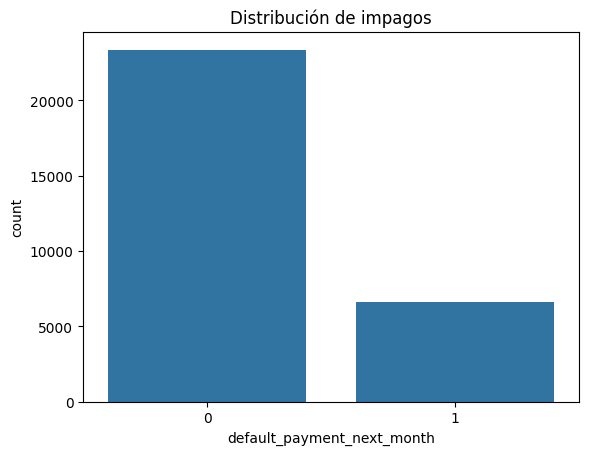

,id,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Valores nulos por columna:
id                            0
limit_bal                     0
sex                           0
education                     0
marriage                      0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt1                     0
bill_amt2                     0
bill_amt3                     0
bill_amt4                     0
bill_amt5                     0
bill_amt6                     0
pay_amt1                      0
pay_amt2                      0
pay_amt3                      0
pay_amt4                      0
pay_amt5                      0
pay_amt6                      0
default_payment_next_month    0
dtype: int64


In [5]:
# Visualizamos distribución de la variable objetivo
sns.countplot(x="default_payment_next_month", data=datos)
plt.title("Distribución de impagos")
plt.show()

# Estadísticas descriptivas de las variables
display(datos.describe())

# Comprobación de valores nulos
print("Valores nulos por columna:")
print(datos.isnull().sum())


Preparar datos para el modelo

In [6]:
# Separamos variables de entrenamiento (X) y variable objetivo (y)
X = datos.drop(["id", "default_payment_next_month"], axis=1)
y = datos["default_payment_next_month"]

# Dividimos en conjunto de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Escalamos las variables para mejorar el rendimiento de la regresión logística
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Entrenar modelo

In [7]:
modelo = RandomForestClassifier(
    n_estimators=200,         # número de árboles
    max_depth=10,             # profundidad máxima de los árboles
    random_state=42,
    class_weight='balanced'   # balancea las clases automáticamente
)
modelo.fit(X_train_scaled, y_train)
print("Modelo Random Forest entrenado con éxito.")  


Modelo Random Forest entrenado con éxito.


Evaluación del modelo

Exactitud (accuracy): 0.7891666666666667

Informe de clasificación:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      4673
           1       0.52      0.56      0.54      1327

    accuracy                           0.79      6000
   macro avg       0.70      0.71      0.70      6000
weighted avg       0.80      0.79      0.79      6000



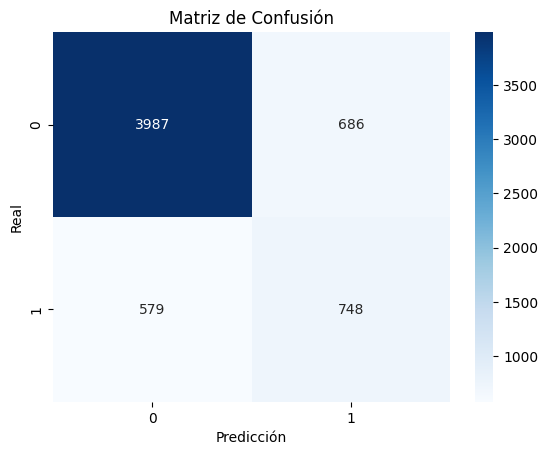

In [8]:
y_pred = modelo.predict(X_test_scaled)

print("Exactitud (accuracy):", accuracy_score(y_test, y_pred))
print("\nInforme de clasificación:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()



Probar con un cliente nuevo

In [9]:
cliente = X_test.iloc[0:1]  # tomamos un ejemplo del conjunto de prueba
cliente_escalado = scaler.transform(cliente)
prediccion = modelo.predict(cliente_escalado)
print("Predicción del cliente:", "Impago" if prediccion[0]==1 else "No impago")

Predicción del cliente: No impago
